In [11]:
from Bio.PDB import PDBParser, PDBIO
from Bio.SeqUtils import seq1

CD20 = 'FMRESKTLGAVQIMNGLFHIALGGLLMIPAGIYAPICVTVWYPLWGGIMYIISGSLLAATEKNSRKCLVKGKMIMNSLSLFAAISGMILSIMDILNIKISHFLKMESLNFIRAHTPYINIYNCEPANPSEKNSPSTQYCYSIQSLFLGILSVMLIFAFFQELVIAGIVE'

CART = 'MALPVTALLLPLALLLHAARP<>GSTSGSGKPGSGEGSTKGLEPKSCDKTHTCPPCPDPKFWVLVVVGGVLACYSLLVTVAFIIFWVRSKRSRLLHSDYMNMTPRRPGPTRKHYQPYAPPRDFAAYRSRVKFSRSADAPAYKQGQNQLYNELNLGRREEYDVLDKRRGRDPEMGGKPRRKNPQEGLYNELQKDKMAEAYSEIGMKGERRRGKGHDGLYQGLSTATKDTYDALHMQALPPR'

def get_sequence_from_pdb(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure('6Y97', pdb_file)
    for chain in structure.get_chains():
        sequence = ""
        for residue in chain.get_residues():
            resname = residue.get_resname()
            sequence += seq1(resname)
    return sequence


<Axes: >

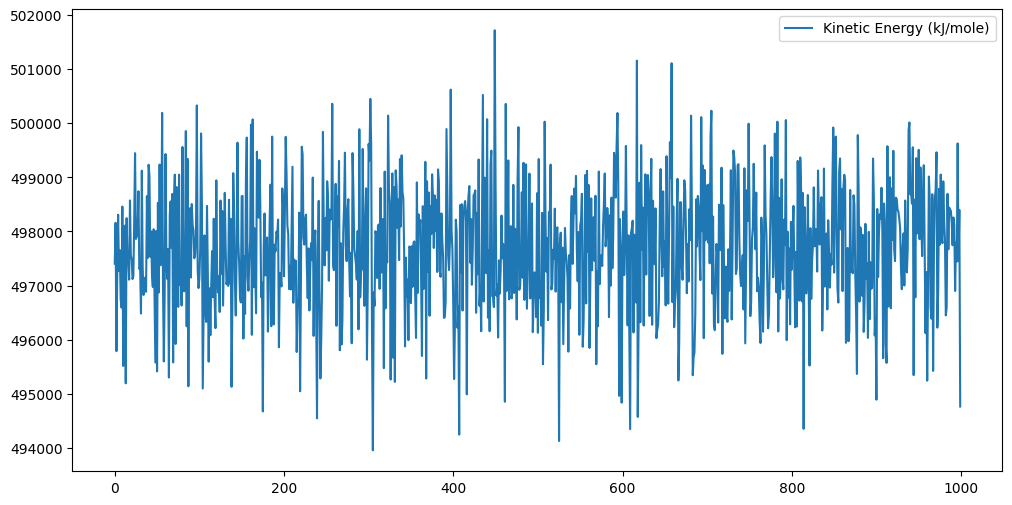

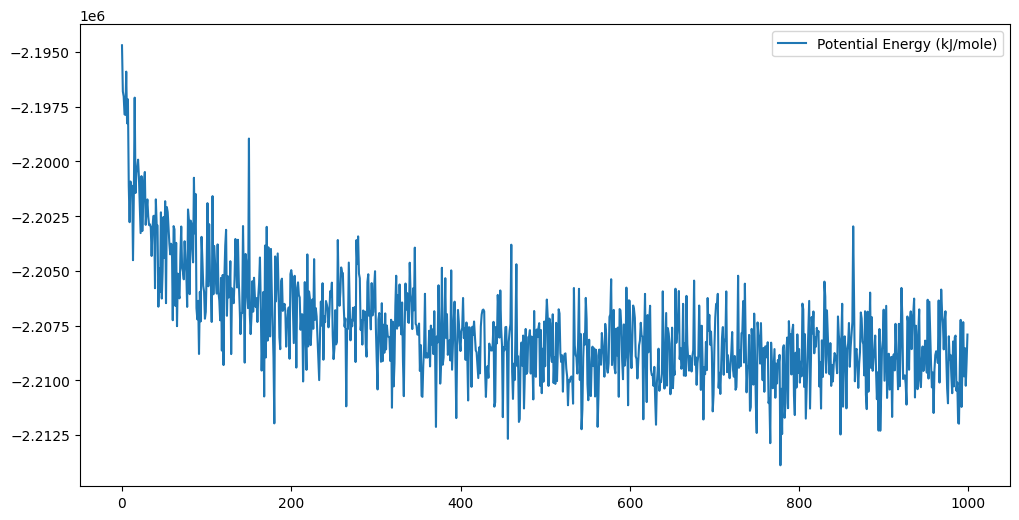

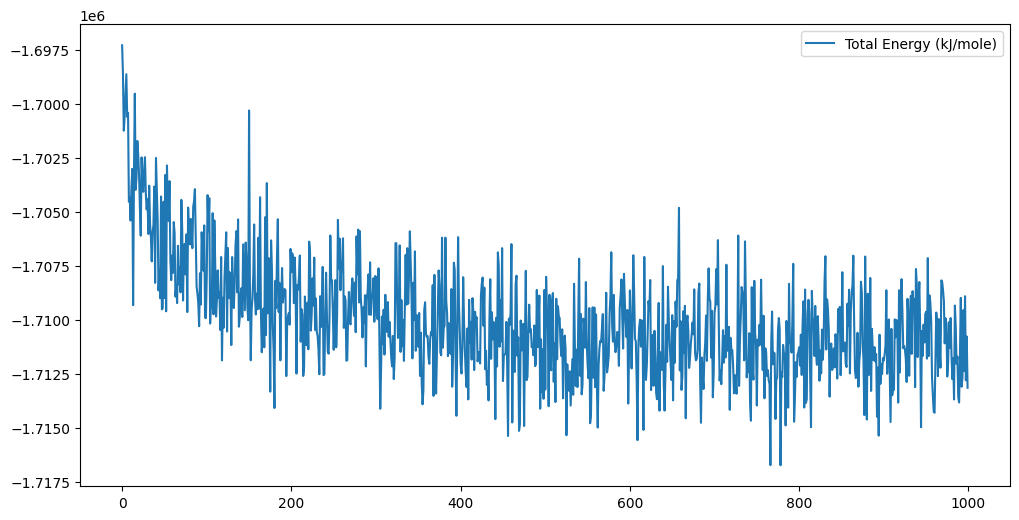

In [26]:
# open logger file and plot all columns
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('logger', sep='\t')

# plot columns with Energy in the name
df.plot(kind='line', y='Kinetic Energy (kJ/mole)', figsize=(12, 6))
df.plot(kind='line', y='Potential Energy (kJ/mole)', figsize=(12, 6))
df.plot(kind='line', y='Total Energy (kJ/mole)', figsize=(12, 6))


### Entire CAR-T Design

In [20]:
# open the data/stefano/fullCART/CARTCD20__best_38.pdb and get the sequence using biopython
pdb_file = '../data/stefano/fullCART/CARTCD20__best_38.pdb'

seq = get_sequence_from_pdb(pdb_file)

# remove CD20 from seq
seq = seq.replace(CD20, '')

# remove leader
seq = seq.replace('MALPVTALLLPLALLLHAARP', '')

# get 80 residue binder, from the start
seq = seq[:80]

# print a FASTA file with CD20 dimer (it means you have to print the CD20 string twice) and the binder
print(f'>CD20_monomer\n{CD20}\n>CD20_monomer{CD20}\n>Binder\n{seq}')

# print it into a fasta file in data/stefano/fullCART/binder.fasta
with open('../data/stefano/fullCART/binder.fasta', 'w') as f:
    f.write(f'>CD20_monomer\n{CD20}\n>CD20_monomer{CD20}\n>Binder\n{seq}')



>CD20_monomer
FMRESKTLGAVQIMNGLFHIALGGLLMIPAGIYAPICVTVWYPLWGGIMYIISGSLLAATEKNSRKCLVKGKMIMNSLSLFAAISGMILSIMDILNIKISHFLKMESLNFIRAHTPYINIYNCEPANPSEKNSPSTQYCYSIQSLFLGILSVMLIFAFFQELVIAGIVE
>CD20_monomerFMRESKTLGAVQIMNGLFHIALGGLLMIPAGIYAPICVTVWYPLWGGIMYIISGSLLAATEKNSRKCLVKGKMIMNSLSLFAAISGMILSIMDILNIKISHFLKMESLNFIRAHTPYINIYNCEPANPSEKNSPSTQYCYSIQSLFLGILSVMLIFAFFQELVIAGIVE
>Binder
LATVSAYNEYVQGDHKSPTKSEVGEIYKSAIDKNINHHKWIPVLPGFLESDKGMFVFSYFHGDIIASDVSGKHIYTMHFG


/home/jakub/anaconda3/envs/esm-size/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5130
  warnings.warn(


In [55]:
# Align epitope structures

# load the structures
CD20_dimer_structure = PDBParser().get_structure('6Y97', '../data/cd20/6Y97_reindexed.pdb')
# this one has the two monomers and its epitope
# just get chain A from this structure

filepath = '../data/designs/simple/fixedA.pdb'
simple_design_1 = PDBParser().get_structure('simple', filepath)
simple_design_2 = simple_design_1.copy()

from Bio import PDB
from Bio.PDB import Superimposer

# align first of the designs to CD20 dimer chain A
cd20_atoms_chain_A = []
simple_design_atoms = []

for model in CD20_dimer_structure:
    for chain in model:
        if chain.id == 'A':
            residues = [i for i in chain.get_residues()]
            for residue in residues:
                if residue.has_id("CA"):
                    cd20_atoms_chain_A.append(residue["CA"])

for model in simple_design_1:
    for chain in model:
        if chain.id == 'A':
            residues = [i for i in chain.get_residues()]
            for residue in residues:
                if residue.has_id("CA"):
                    simple_design_atoms.append(residue["CA"])


super_imposer = Superimposer()
super_imposer.set_atoms(cd20_atoms_chain_A, simple_design_atoms)
super_imposer.apply(simple_design_1.get_atoms()) # epitope 1 is aligned to CD20

# now do the same with simple_design_2
cd20_atoms_chain_B = []
simple_design_atoms = []

for model in CD20_dimer_structure:
    for chain in model:
        if chain.id == 'B':
            residues = [i for i in chain.get_residues()]
            for residue in residues:
                if residue.has_id("CA"):
                    cd20_atoms_chain_B.append(residue["CA"])

for model in simple_design_2:
    for chain in model:
        if chain.id == 'A':
            residues = [i for i in chain.get_residues()]
            for residue in residues:
                if residue.has_id("CA"):
                    simple_design_atoms.append(residue["CA"])

super_imposer = Superimposer()
super_imposer.set_atoms(cd20_atoms_chain_B, simple_design_atoms)
super_imposer.apply(simple_design_2.get_atoms()) # epitope 2 is aligned to CD20

# # just get the binders from each simple_designs (chains B)
# # i.e. remove chain A from the simple_design_1 and simple_design_2
# for model in simple_design_1:
#     for chain in model:
#         if chain.id == 'A':
#             model.detach_child(chain.id)

# for model in simple_design_2:
#     for chain in model:
#         if chain.id == 'A':
#             model.detach_child(chain.id)
# # create a new structure with the binders and the CD20 dimer
# new_structure = PDB.Structure.Structure('binder_cd20_dimer')
# new_model = PDB.Model.Model(0)
# new_structure.add(new_model)

# # add the binders
# for chain in simple_design_1.get_chains():
#     chain.id = 'A'
#     new_model.add(chain)
# for chain in simple_design_2.get_chains():
#     chain.id = 'B'
#     new_model.add(chain)
# chain_ids = ['C', 'D']
# for i, chain in enumerate(CD20_dimer_structure.get_chains()):
#     chain.id = chain_ids[i]
#     new_model.add(chain)

# do it differently, rather combine the two simple_designs into one structure
# and then add the CD20 dimer
new_structure = PDB.Structure.Structure('binder_cd20_dimer')
new_model = PDB.Model.Model(0)
new_structure.add(new_model)

# add the binders
chains = ['A', 'B', 'C', 'D']
i = 0
for chain in simple_design_1.get_chains():
    chain.id = chains[i]
    new_model.add(chain)
    i += 1

for chain in simple_design_2.get_chains():
    chain.id = chains[i]
    new_model.add(chain)
    i += 1

io = PDB.PDBIO()
io.set_structure(new_structure)
io.save("binder_cd20_dimer.pdb")

